## **Deep Learning Models**

# **Preprocessing Pipeline**

**Step:** Preparing the Price–Sentiment Dataset for Deep Learning

Since the raw dataset contains mixed data types, missing values, and unaligned dates, the preprocessing pipeline converts it into a clean, chronological, model-ready time series.

**Process:**
The CSV file is loaded, the Date column is converted to datetime format, and the entire dataset is sorted chronologically to preserve time dependence. Missing values in price-related fields are resolved using forward- and backward-filling, while missing sentiment values are replaced with zero to represent days with no tweet activity. Non-numeric identifiers such as stock names and tickers are removed so only numerical features enter the learning pipeline.

**Mechanism:**
A binary target variable is created by comparing each day’s Close price to the next day’s Close, generating the label needed for directional prediction. The dataset is then split into training, validation, and test sets using strict time-based segmentation to avoid future information leakage. Feature scaling is applied using MinMaxScaler fitted only on the training segment, and the scaled data is converted into sliding 30-day sequences so that each sample forms a 3D tensor of shape (30 timesteps × n_features).

**Outcome:**
The final output consists of preprocessed NumPy arrays containing well-structured input sequences and aligned binary labels. These arrays form the foundation for all deep learning models by providing consistent, temporally accurate windows of market and sentiment history.

In [ ]:




!pip install numpy pandas scikit-learn --quiet

# ============================================================
# 2. IMPORTS
# ============================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler



from google.colab import files
uploaded = files.upload()

# Adjust the file name if needed
file_name = 'merged_sentiment_price_data.csv'
df = pd.read_csv(file_name)

print("Raw data shape:", df.shape)
print(df.head())

# ============================================================
# 4. BASIC CLEANING & SORTING BY DATE
# ============================================================

# Ensure Date column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by chronological order
df = df.sort_values('Date').reset_index(drop=True)
print("\nAfter sorting by Date:")
print(df[['Date', 'Open', 'High', 'Low', 'Close']].head())

# ============================================================
# 5. HANDLE MISSING VALUES
# ============================================================

# Check missing values
print("\nMissing values before handling:")
print(df.isna().sum())

# Forward-fill / back-fill for price data
price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df[price_cols] = df[price_cols].fillna(method='ffill').fillna(method='bfill')

# For sentiment-related columns, fill missing with 0 (no sentiment / no tweets)
sentiment_cols = ['avg_sentiment', 'tweet_count']
for col in sentiment_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

print("\nMissing values after handling:")
print(df.isna().sum())

# ============================================================
# 6. DROP NON-NUMERIC / UNUSED COLUMNS FOR MODEL INPUT
# ============================================================

# We drop string/categorical columns that are not directly used as features
drop_cols = ['Stock Name', 'Ticker', 'date_only']  # will be ignored if not present
for c in drop_cols:
    if c in df.columns:
        df = df.drop(columns=[c])

# Keep Date separately (useful for reference but not as a feature)
dates = df['Date'].copy()
df = df.drop(columns=['Date'])

print("\nColumns after dropping non-feature text columns:")
print(df.columns)

# ============================================================
# 7. CREATE TARGET COLUMN: target_direction (0 = down, 1 = up)
# ============================================================

# Direction based on next day's Close vs today's Close
# NOTE: This uses the original Close column which is still present in df
df['target_direction'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Last row has no "next day" → target_direction will be NaN; drop it
df = df[:-1]  # drop last row
dates = dates[:-1]  # align dates with df

print("\nSample of target_direction:")
print(df[['Close', 'target_direction']].head(10))

# ============================================================
# 8. DEFINE FEATURES AND TARGET ARRAYS
# ============================================================

# Feature columns = all numeric columns except the target
feature_cols = [col for col in df.columns if col != 'target_direction']

X_all = df[feature_cols].values
y_all = df['target_direction'].values.astype(int)

print("\nFeature columns used:")
print(feature_cols)
print("X_all shape (rows, features):", X_all.shape)
print("y_all shape:", y_all.shape)

# ============================================================
# 9. TRAIN / VAL / TEST SPLIT (TIME-BASED, NO SHUFFLE)
# ============================================================

n_samples = len(df)
train_end = int(n_samples * 0.70)    # first 70% for training
val_end   = int(n_samples * 0.85)    # next 15% for validation, last 15% for test

print("\nTotal samples:", n_samples)
print("Train end index:", train_end)
print("Val end index:", val_end)

# ============================================================
# 10. SCALE FEATURES (FIT SCALER ONLY ON TRAINING PART)
# ============================================================

scaler = MinMaxScaler()

# Fit on training portion only to avoid data leakage
X_train_raw = X_all[:train_end]
scaler.fit(X_train_raw)

# Transform entire series with this scaler
X_all_scaled = scaler.transform(X_all)

print("\nScaled feature sample (first 5 rows):")
print(X_all_scaled[:5])

# ============================================================
# 11. CONVERT TO TIME-SERIES SEQUENCES FOR DL (LSTM/GRU)
# ============================================================

SEQ_LENGTH = 30  # number of past days used to predict next movement

X_train_seq, y_train_seq = [], []
X_val_seq,   y_val_seq   = [], []
X_test_seq,  y_test_seq  = [], []

# We created target_direction for each day except last, so:
# For label at index i, we will use the previous SEQ_LENGTH days (including i):
# window: [i-SEQ_LENGTH+1 ... i]
for i in range(SEQ_LENGTH - 1, n_samples):
    # build window of features for this label index i
    x_window = X_all_scaled[i - SEQ_LENGTH + 1 : i + 1]
    y_label = y_all[i]

    # Decide which set this sample belongs to based on label index i
    if i < train_end:
        X_train_seq.append(x_window)
        y_train_seq.append(y_label)
    elif i < val_end:
        X_val_seq.append(x_window)
        y_val_seq.append(y_label)
    else:
        X_test_seq.append(x_window)
        y_test_seq.append(y_label)

X_train_seq = np.array(X_train_seq)
y_train_seq = np.array(y_train_seq)
X_val_seq   = np.array(X_val_seq)
y_val_seq   = np.array(y_val_seq)
X_test_seq  = np.array(X_test_seq)
y_test_seq  = np.array(y_test_seq)

print("\nAfter sequence generation:")
print("X_train_seq shape:", X_train_seq.shape)  # (samples, SEQ_LENGTH, features)
print("y_train_seq shape:", y_train_seq.shape)
print("X_val_seq shape:", X_val_seq.shape)
print("y_val_seq shape:", y_val_seq.shape)
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)

# ============================================================
# 12. OPTIONAL: SAVE PREPROCESSED ARRAYS FOR LATER MODELING
# ============================================================

# You can skip this if you don't want to save
np.save('X_train_seq.npy', X_train_seq)
np.save('y_train_seq.npy', y_train_seq)
np.save('X_val_seq.npy',   X_val_seq)
np.save('y_val_seq.npy',   y_val_seq)
np.save('X_test_seq.npy',  X_test_seq)
np.save('y_test_seq.npy',  y_test_seq)

print("\nPreprocessed sequence data saved as .npy files.")
print("You can now load these in another notebook and build your DL model (LSTM/GRU/Transformer).")

KeyboardInterrupt: 

#**LSTM Model**
**Step:** Sequential Learning with LSTM

Since the input consists of 30-day sequences with multiple financial and sentiment features, the LSTM model learns how these values evolve over time.

**Process:**
The model reads the sequence one timestep at a time and updates its internal memory (cell state) to capture short-term patterns such as momentum, volatility shifts, and sentiment changes.

**Mechanism:**
LSTM gates (input, forget, output) control how much information from each day is stored, updated, or discarded, allowing the model to retain relevant temporal structure.

**Outcome:**
A final hidden state embedding summarizing the full 30-day window is passed to dense layers to predict next-day stock direction.

X_train_seq shape: (4380, 30, 8)
y_train_seq shape: (4380,)
X_val_seq shape: (945, 30, 8)
y_val_seq shape: (945,)
X_test_seq shape: (945, 30, 8)
y_test_seq shape: (945,)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 30, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,193 (125.75 KB)

 Trainable params: 32,193 (125.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5015 - auc: 0.4899 - loss: 0.6942 - precision: 0.5073 - recall: 0.6681
Epoch 1: val_loss improved from inf to 0.68978, saving model to best_lstm_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.5016 - auc: 0.4901 - loss: 0.6941 - precision: 0.5073 - recall: 0.6673 - val_accuracy: 0.5714 - val_auc: 0.6141 - val_loss: 0.6898 - val_precision: 0.5554 - val_recall: 0.7389
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5946 - auc: 0.6216 - loss: 0.6719 - precision: 0.6025 - recall: 0.6041
Epoch 2: val_loss improved from 0.68978 to 0.54238, saving model to best_lstm_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.5949 - auc: 0.6220 - loss: 0.6717 - precision: 0.6027 - recall: 0.6044 - val_accuracy: 0.7365 - val_auc: 0.8211 - val_loss: 0.5424 - val_precision: 0.7181 - val_recall: 0.7832
Epoch 3/50
136/137 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7395 - auc: 0.8

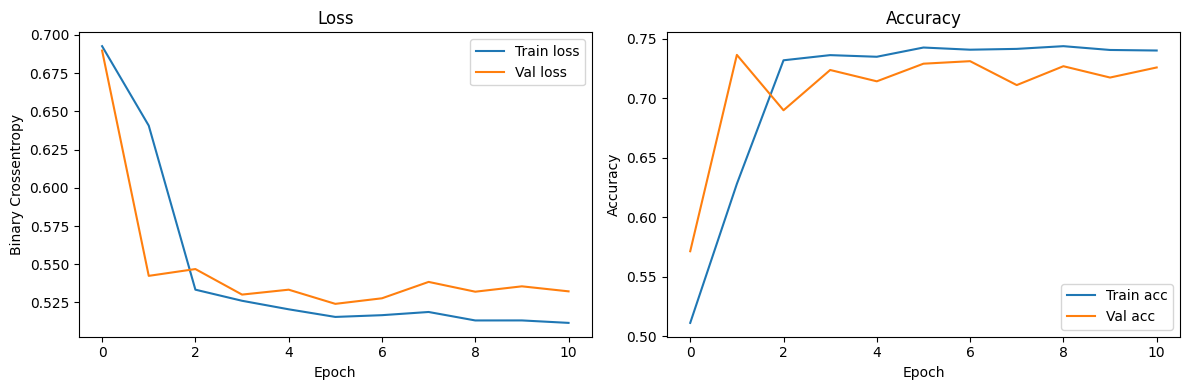

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Test Accuracy: 0.7672
Test ROC-AUC: 0.8584

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.8144    0.6810    0.7418       464
           1     0.7343    0.8503    0.7881       481

    accuracy                         0.7672       945
   macro avg     0.7744    0.7657    0.7649       945
weighted avg     0.7736    0.7672    0.7653       945

Confusion Matrix:
 [[316 148]
 [ 72 409]]


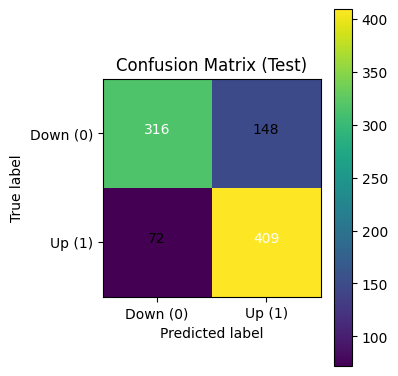


Model saved as final_lstm_direction_model.keras


In [ ]:
# ============================================================
# LSTM MODEL FOR STOCK DIRECTION PREDICTION (COLAB READY)
# Assumes you already ran the preprocessing code and saved:
#   X_train_seq.npy, y_train_seq.npy, X_val_seq.npy, y_val_seq.npy,
#   X_test_seq.npy, y_test_seq.npy
# ============================================================

# 1. INSTALL REQUIRED LIBRARIES (Colab)
!pip install scikit-learn --quiet

# 2. IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score
)

# 3. LOAD PREPROCESSED SEQUENCE DATA
#    (Make sure these files exist in your Colab working directory)
X_train_seq = np.load('X_train_seq.npy')
y_train_seq = np.load('y_train_seq.npy')
X_val_seq   = np.load('X_val_seq.npy')
y_val_seq   = np.load('y_val_seq.npy')
X_test_seq  = np.load('X_test_seq.npy')
y_test_seq  = np.load('y_test_seq.npy')

print("X_train_seq shape:", X_train_seq.shape)  # (samples, timesteps, features)
print("y_train_seq shape:", y_train_seq.shape)
print("X_val_seq shape:", X_val_seq.shape)
print("y_val_seq shape:", y_val_seq.shape)
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)

# 4. SET RANDOM SEEDS FOR REPRODUCIBILITY (OPTIONAL BUT RECOMMENDED)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 5. DEFINE LSTM MODEL
timesteps = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(timesteps, n_features)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # binary classification (0/1)
])

model.summary()

# 6. COMPILE MODEL
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# 7. DEFINE CALLBACKS
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_lstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# 8. TRAIN MODEL
EPOCHS = 50
BATCH_SIZE = 32

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# 9. PLOT TRAINING HISTORY
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 10. EVALUATE ON TEST SET
# Predict probabilities and convert to class labels
y_test_proba = model.predict(X_test_seq).ravel()
y_test_pred = (y_test_proba >= 0.5).astype(int)

# Basic metrics
test_accuracy = accuracy_score(y_test_seq, y_test_pred)
test_auc = roc_auc_score(y_test_seq, y_test_proba)

print("\nTest Accuracy: {:.4f}".format(test_accuracy))
print("Test ROC-AUC: {:.4f}".format(test_auc))

# Detailed classification report
print("\nClassification Report (Test):")
print(classification_report(y_test_seq, y_test_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test_seq, y_test_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Test)')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Down (0)', 'Up (1)'])
plt.yticks(tick_marks, ['Down (0)', 'Up (1)'])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# 11. SAVE FINAL MODEL (OPTIONAL)
model.save('final_lstm_direction_model.keras')
print("\nModel saved as final_lstm_direction_model.keras")


# **Common Setup for Deep Learning Models**

Since all models in this notebook use the same preprocessed time-series inputs, we load the saved NumPy arrays and prepare a reproducible training environment.

**Process:**
We install required libraries, set global random seeds, and load the previously generated training, validation, and test sequences. These sequences were created from the 30-day sliding windows produced during preprocessing.

**Components:**

X_train_seq, X_val_seq, X_test_seq: 3-D arrays of shape (samples, timesteps, features) used as inputs to the DL models.

y_train_seq, y_val_seq, y_test_seq: Corresponding labels containing next-day direction values (0 or 1).

timesteps: The fixed sequence length (30 days).

n_features: Number of numerical features per day after preprocessing.

**Outcome:**
A standardized and reproducible data environment that every model (LSTM, GRU, BiLSTM, Attention, etc.) can directly train on without repeating preprocessing steps.

In [ ]:
# ============================================================
# COMMON SETUP FOR ALL MODELS (RUN ONCE)
# ============================================================

!pip install scikit-learn --quiet

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score
)

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load preprocessed sequences
X_train_seq = np.load('X_train_seq.npy')
y_train_seq = np.load('y_train_seq.npy')
X_val_seq   = np.load('X_val_seq.npy')
y_val_seq   = np.load('y_val_seq.npy')
X_test_seq  = np.load('X_test_seq.npy')
y_test_seq  = np.load('y_test_seq.npy')

print("X_train_seq shape:", X_train_seq.shape)  # (samples, timesteps, features)
print("y_train_seq shape:", y_train_seq.shape)
print("X_val_seq shape:",   X_val_seq.shape)
print("y_val_seq shape:",   y_val_seq.shape)
print("X_test_seq shape:",  X_test_seq.shape)
print("y_test_seq shape:",  y_test_seq.shape)

timesteps = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]


X_train_seq shape: (4380, 30, 8)
y_train_seq shape: (4380,)
X_val_seq shape: (945, 30, 8)
y_val_seq shape: (945,)
X_test_seq shape: (945, 30, 8)
y_test_seq shape: (945,)


# **GRU Model**
**Step**: Temporal Modeling with GRU

The GRU model processes the same 30-day windows but uses a simplified gating structure for efficiency.

**Process:**
The GRU iterates over the sequence, updating a single hidden state that captures the key trends without maintaining a separate cell state.

**Mechanism:**
Update and reset gates determine how much past information influences the current state, enabling fast and stable training on financial sequences.

**Outcome:**
A compressed temporal representation of the sequence is used to classify whether the next day’s movement will be up or down.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, 30, 64)         │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,705 (96.50 KB)

 Trainable params: 24,705 (96.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5856 - auc: 0.6272 - loss: 0.6622 - precision: 0.5675 - recall: 0.8384
Epoch 1: val_loss improved from inf to 0.53709, saving model to best_gru_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - accuracy: 0.5861 - auc: 0.6279 - loss: 0.6619 - precision: 0.5679 - recall: 0.8379 - val_accuracy: 0.7153 - val_auc: 0.8248 - val_loss: 0.5371 - val_precision: 0.6678 - val_recall: 0.8632
Epoch 2/50
136/137 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7555 - auc: 0.8321 - loss: 0.5085 - precision: 0.7422 - recall: 0.7950
Epoch 2: val_loss improved from 0.53709 to 0.53021, saving model to best_gru_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.7553 - auc: 0.8319 - loss: 0.5087 - precision: 0.7420 - recall: 0.7947 - val_accuracy: 0.7164 - val_auc: 0.8268 - val_loss: 0.5302 - val_precision: 0.6711 - val_recall: 0.8547
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7520 - auc: 0.837

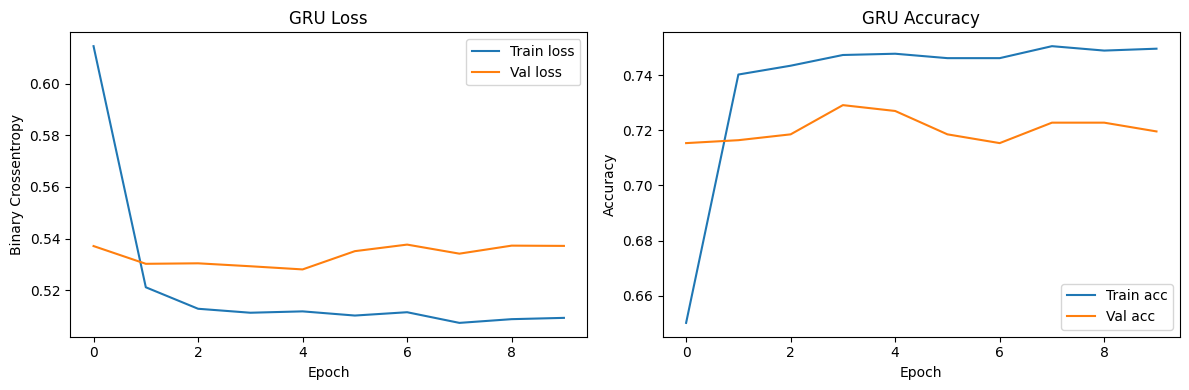

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step

[GRU] Test Accuracy: 0.7672
[GRU] Test ROC-AUC: 0.8578

[GRU] Classification Report:
              precision    recall  f1-score   support

           0     0.8228    0.6703    0.7387       464
           1     0.7302    0.8607    0.7901       481

    accuracy                         0.7672       945
   macro avg     0.7765    0.7655    0.7644       945
weighted avg     0.7756    0.7672    0.7649       945

[GRU] Confusion Matrix:
 [[311 153]
 [ 67 414]]


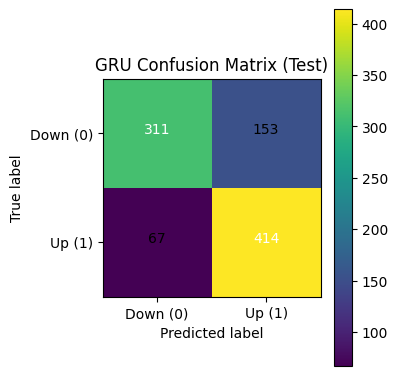


GRU model saved as final_gru_direction_model.keras


In [ ]:
# ============================================================
# MODEL 1: GRU-BASED CLASSIFIER
# ============================================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define GRU model
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(timesteps, n_features)),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # binary classification
])

gru_model.summary()

# Compile
gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Callbacks
early_stop_gru = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_gru = ModelCheckpoint(
    'best_gru_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train
EPOCHS = 50
BATCH_SIZE = 32

history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_gru, checkpoint_gru],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Train loss')
plt.plot(history_gru.history['val_loss'], label='Val loss')
plt.title('GRU Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gru.history['accuracy'], label='Train acc')
plt.plot(history_gru.history['val_accuracy'], label='Val acc')
plt.title('GRU Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation on test set
y_test_proba_gru = gru_model.predict(X_test_seq).ravel()
y_test_pred_gru = (y_test_proba_gru >= 0.5).astype(int)

print("\n[GRU] Test Accuracy: {:.4f}".format(accuracy_score(y_test_seq, y_test_pred_gru)))
print("[GRU] Test ROC-AUC: {:.4f}".format(roc_auc_score(y_test_seq, y_test_proba_gru)))

print("\n[GRU] Classification Report:")
print(classification_report(y_test_seq, y_test_pred_gru, digits=4))

cm_gru = confusion_matrix(y_test_seq, y_test_pred_gru)
print("[GRU] Confusion Matrix:\n", cm_gru)

plt.figure(figsize=(4, 4))
plt.imshow(cm_gru, interpolation='nearest')
plt.title('GRU Confusion Matrix (Test)')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Down (0)', 'Up (1)'])
plt.yticks(tick_marks, ['Down (0)', 'Up (1)'])

thresh = cm_gru.max() / 2.
for i in range(cm_gru.shape[0]):
    for j in range(cm_gru.shape[1]):
        plt.text(
            j, i, format(cm_gru[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm_gru[i, j] > thresh else "black"
        )

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

gru_model.save('final_gru_direction_model.keras')
print("\nGRU model saved as final_gru_direction_model.keras")


# **BiLSTM Model**
**Step:** Bidirectional Sequence Processing

The BiLSTM model reads each 30-day window in both forward and reverse order to improve context extraction.

**Process:**
Forward LSTM → captures early-to-late trends
Backward LSTM → captures late-to-early relationships

**Mechanism:**
The outputs from both directions are concatenated, giving the model a more complete understanding of how sentiment and prices evolve within the window.

**Outcome:**
A richer combined sequence embedding enhances pattern detection before classification.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional) │ (None, 30, 128)        │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,705 (315.25 KB)

 Trainable params: 80,705 (315.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5465 - auc: 0.5535 - loss: 0.6847 - precision: 0.5463 - recall: 0.6677
Epoch 1: val_loss improved from inf to 0.63088, saving model to best_bilstm_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 46s 212ms/step - accuracy: 0.5468 - auc: 0.5540 - loss: 0.6846 - precision: 0.5465 - recall: 0.6674 - val_accuracy: 0.6307 - val_auc: 0.7025 - val_loss: 0.6309 - val_precision: 0.5981 - val_recall: 0.8084
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6743 - auc: 0.7454 - loss: 0.5937 - precision: 0.6818 - recall: 0.6763
Epoch 2: val_loss improved from 0.63088 to 0.55084, saving model to best_bilstm_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6743 - auc: 0.7455 - loss: 0.5936 - precision: 0.6818 - recall: 0.6764 - val_accuracy: 0.7090 - val_auc: 0.8094 - val_loss: 0.5508 - val_precision: 0.6613 - val_recall: 0.8632
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7371 - a

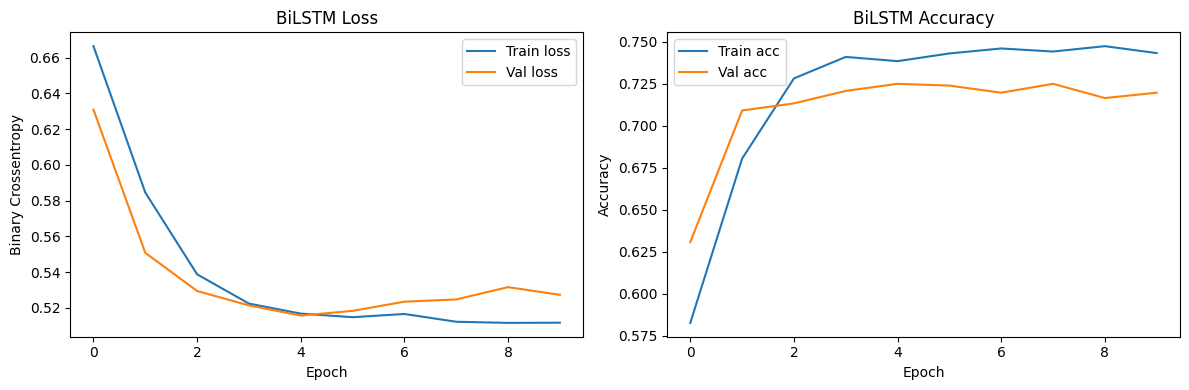

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step

[BiLSTM] Test Accuracy: 0.7630
[BiLSTM] Test ROC-AUC: 0.8598

[BiLSTM] Classification Report:
              precision    recall  f1-score   support

           0     0.8077    0.6789    0.7377       464
           1     0.7315    0.8441    0.7838       481

    accuracy                         0.7630       945
   macro avg     0.7696    0.7615    0.7607       945
weighted avg     0.7689    0.7630    0.7612       945

[BiLSTM] Confusion Matrix:
 [[315 149]
 [ 75 406]]


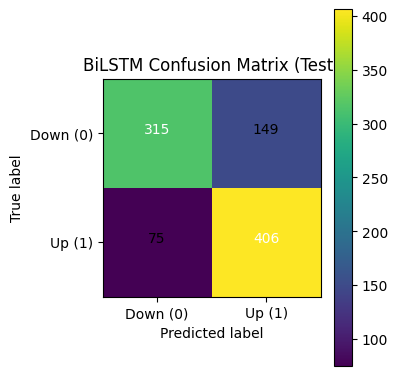


BiLSTM model saved as final_bilstm_direction_model.keras


In [ ]:
# ============================================================
# MODEL 2: BIDIRECTIONAL LSTM CLASSIFIER
# ============================================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define BiLSTM model
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(timesteps, n_features)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

bilstm_model.summary()

# Compile
bilstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Callbacks
early_stop_bilstm = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_bilstm = ModelCheckpoint(
    'best_bilstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train
EPOCHS = 50
BATCH_SIZE = 32

history_bilstm = bilstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_bilstm, checkpoint_bilstm],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_bilstm.history['loss'], label='Train loss')
plt.plot(history_bilstm.history['val_loss'], label='Val loss')
plt.title('BiLSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bilstm.history['accuracy'], label='Train acc')
plt.plot(history_bilstm.history['val_accuracy'], label='Val acc')
plt.title('BiLSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation on test set
y_test_proba_bilstm = bilstm_model.predict(X_test_seq).ravel()
y_test_pred_bilstm = (y_test_proba_bilstm >= 0.5).astype(int)

print("\n[BiLSTM] Test Accuracy: {:.4f}".format(accuracy_score(y_test_seq, y_test_pred_bilstm)))
print("[BiLSTM] Test ROC-AUC: {:.4f}".format(roc_auc_score(y_test_seq, y_test_proba_bilstm)))

print("\n[BiLSTM] Classification Report:")
print(classification_report(y_test_seq, y_test_pred_bilstm, digits=4))

cm_bilstm = confusion_matrix(y_test_seq, y_test_pred_bilstm)
print("[BiLSTM] Confusion Matrix:\n", cm_bilstm)

plt.figure(figsize=(4, 4))
plt.imshow(cm_bilstm, interpolation='nearest')
plt.title('BiLSTM Confusion Matrix (Test)')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Down (0)', 'Up (1)'])
plt.yticks(tick_marks, ['Down (0)', 'Up (1)'])

thresh = cm_bilstm.max() / 2.
for i in range(cm_bilstm.shape[0]):
    for j in range(cm_bilstm.shape[1]):
        plt.text(
            j, i, format(cm_bilstm[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm_bilstm[i, j] > thresh else "black"
        )

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

bilstm_model.save('final_bilstm_direction_model.keras')
print("\nBiLSTM model saved as final_bilstm_direction_model.keras")


# **CNN Model**
**Step:** Local Pattern Extraction

The CNN model treats the 30-day window as a 1-D signal and applies convolutions to capture short-range patterns.

**Process:**
Conv1D filters slide over days to detect local variations such as price spikes, sentiment surges, or volume bursts.

**Mechanism:**
Pooling layers compress the extracted features, reducing sequence length.

**Outcome:**
A flattened feature vector is used for classification, though long-range dependencies are not preserved.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 30, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 30, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,177 (71.00 KB)

 Trainable params: 18,177 (71.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
131/137 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4791 - auc: 0.4768 - loss: 0.6998 - precision: 0.4897 - recall: 0.5378
Epoch 1: val_loss improved from inf to 0.69328, saving model to best_cnn_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4798 - auc: 0.4773 - loss: 0.6996 - precision: 0.4898 - recall: 0.5339 - val_accuracy: 0.4974 - val_auc: 0.5014 - val_loss: 0.6933 - val_precision: 0.5000 - val_recall: 0.1558
Epoch 2/50
136/137 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5108 - auc: 0.5062 - loss: 0.6939 - precision: 0.5203 - recall: 0.5067
Epoch 2: val_loss improved from 0.69328 to 0.69298, saving model to best_cnn_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5107 - auc: 0.5061 - loss: 0.6940 - precision: 0.5201 - recall: 0.5060 - val_accuracy: 0.5026 - val_auc: 0.5152 - val_loss: 0.6930 - val_precision: 0.5026 - val_recall: 1.0000
Epoch 3/50
136/137 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4927 - auc: 0.4926 -

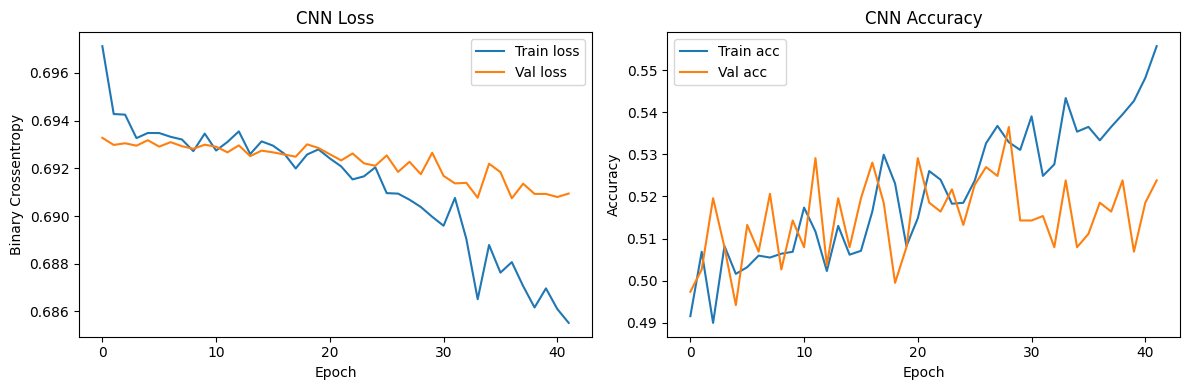

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

[CNN] Test Accuracy: 0.5217
[CNN] Test ROC-AUC: 0.5338

[CNN] Classification Report:
              precision    recall  f1-score   support

           0     0.5224    0.3017    0.3825       464
           1     0.5214    0.7339    0.6097       481

    accuracy                         0.5217       945
   macro avg     0.5219    0.5178    0.4961       945
weighted avg     0.5219    0.5217    0.4981       945

[CNN] Confusion Matrix:
 [[140 324]
 [128 353]]


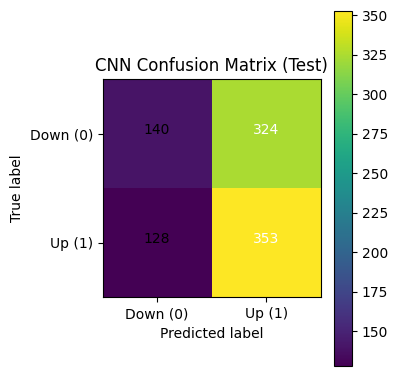


CNN model saved as final_cnn_direction_model.keras


In [ ]:
# ============================================================
# MODEL 3: 1D CONVOLUTIONAL NEURAL NETWORK (CNN) CLASSIFIER
# ============================================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu',
           input_shape=(timesteps, n_features)),
    Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn_model.summary()

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

early_stop_cnn = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_cnn = ModelCheckpoint(
    'best_cnn_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

EPOCHS = 50
BATCH_SIZE = 32

history_cnn = cnn_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_cnn, checkpoint_cnn],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Train loss')
plt.plot(history_cnn.history['val_loss'], label='Val loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Train acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val acc')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation on test set
y_test_proba_cnn = cnn_model.predict(X_test_seq).ravel()
y_test_pred_cnn = (y_test_proba_cnn >= 0.5).astype(int)

print("\n[CNN] Test Accuracy: {:.4f}".format(accuracy_score(y_test_seq, y_test_pred_cnn)))
print("[CNN] Test ROC-AUC: {:.4f}".format(roc_auc_score(y_test_seq, y_test_proba_cnn)))

print("\n[CNN] Classification Report:")
print(classification_report(y_test_seq, y_test_pred_cnn, digits=4))

cm_cnn = confusion_matrix(y_test_seq, y_test_pred_cnn)
print("[CNN] Confusion Matrix:\n", cm_cnn)

plt.figure(figsize=(4, 4))
plt.imshow(cm_cnn, interpolation='nearest')
plt.title('CNN Confusion Matrix (Test)')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Down (0)', 'Up (1)'])
plt.yticks(tick_marks, ['Down (0)', 'Up (1)'])

thresh = cm_cnn.max() / 2.
for i in range(cm_cnn.shape[0]):
    for j in range(cm_cnn.shape[1]):
        plt.text(
            j, i, format(cm_cnn[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm_cnn[i, j] > thresh else "black"
        )

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

cnn_model.save('final_cnn_direction_model.keras')
print("\nCNN model saved as final_cnn_direction_model.keras")


# **CNN + LSTM Model**
**Step:** Hybrid Local + Sequential Modeling

This model combines convolutional layers with LSTM memory.

**Process:**
CNN extracts short-term temporal features → LSTM models their sequential evolution.

**Mechanism:**
The CNN output is reshaped into a reduced sequence fed into LSTM layers for temporal reasoning.

**Outcome:**
Better representation of local patterns but sometimes loses too much temporal resolution, affecting accuracy.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 30, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 15, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,089 (191.75 KB)

 Trainable params: 49,089 (191.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
135/137 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4987 - auc: 0.4972 - loss: 0.6939 - precision: 0.5039 - recall: 0.7765
Epoch 1: val_loss improved from inf to 0.69318, saving model to best_cnn_lstm_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4986 - auc: 0.4973 - loss: 0.6939 - precision: 0.5037 - recall: 0.7724 - val_accuracy: 0.5026 - val_auc: 0.5032 - val_loss: 0.6932 - val_precision: 0.5026 - val_recall: 1.0000
Epoch 2/50
133/137 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4992 - auc: 0.4752 - loss: 0.6937 - precision: 0.5045 - recall: 0.7616
Epoch 2: val_loss did not improve from 0.69318
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4993 - auc: 0.4759 - loss: 0.6937 - precision: 0.5043 - recall: 0.7527 - val_accuracy: 0.4974 - val_auc: 0.5051 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
136/137 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4967 - auc: 0.5146 - loss: 0.6931 - precision: 0

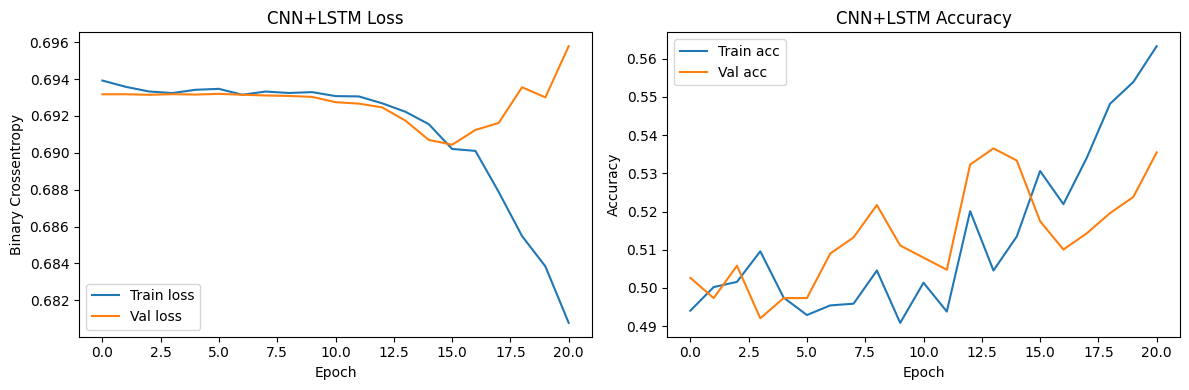

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

[CNN+LSTM] Test Accuracy: 0.5206
[CNN+LSTM] Test ROC-AUC: 0.5096

[CNN+LSTM] Classification Report:
              precision    recall  f1-score   support

           0     0.5104    0.5819    0.5438       464
           1     0.5337    0.4615    0.4950       481

    accuracy                         0.5206       945
   macro avg     0.5220    0.5217    0.5194       945
weighted avg     0.5222    0.5206    0.5190       945

[CNN+LSTM] Confusion Matrix:
 [[270 194]
 [259 222]]


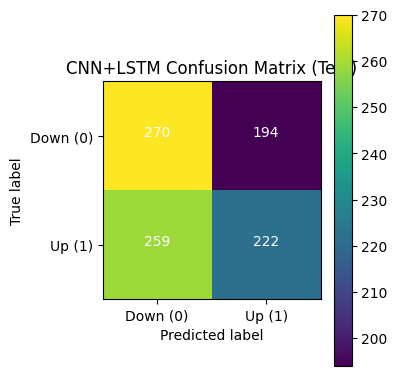


CNN+LSTM model saved as final_cnn_lstm_direction_model.keras


In [ ]:
# ============================================================
# MODEL 4: CNN + LSTM HYBRID CLASSIFIER
# ============================================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

cnn_lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu',
           input_shape=(timesteps, n_features)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_lstm_model.summary()

cnn_lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

early_stop_cnnlstm = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_cnnlstm = ModelCheckpoint(
    'best_cnn_lstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

EPOCHS = 50
BATCH_SIZE = 32

history_cnnlstm = cnn_lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_cnnlstm, checkpoint_cnnlstm],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnnlstm.history['loss'], label='Train loss')
plt.plot(history_cnnlstm.history['val_loss'], label='Val loss')
plt.title('CNN+LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnnlstm.history['accuracy'], label='Train acc')
plt.plot(history_cnnlstm.history['val_accuracy'], label='Val acc')
plt.title('CNN+LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation on test set
y_test_proba_cnnlstm = cnn_lstm_model.predict(X_test_seq).ravel()
y_test_pred_cnnlstm = (y_test_proba_cnnlstm >= 0.5).astype(int)

print("\n[CNN+LSTM] Test Accuracy: {:.4f}".format(accuracy_score(y_test_seq, y_test_pred_cnnlstm)))
print("[CNN+LSTM] Test ROC-AUC: {:.4f}".format(roc_auc_score(y_test_seq, y_test_proba_cnnlstm)))

print("\n[CNN+LSTM] Classification Report:")
print(classification_report(y_test_seq, y_test_pred_cnnlstm, digits=4))

cm_cnnlstm = confusion_matrix(y_test_seq, y_test_pred_cnnlstm)
print("[CNN+LSTM] Confusion Matrix:\n", cm_cnnlstm)

plt.figure(figsize=(4, 4))
plt.imshow(cm_cnnlstm, interpolation='nearest')
plt.title('CNN+LSTM Confusion Matrix (Test)')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Down (0)', 'Up (1)'])
plt.yticks(tick_marks, ['Down (0)', 'Up (1)'])

thresh = cm_cnnlstm.max() / 2.
for i in range(cm_cnnlstm.shape[0]):
    for j in range(cm_cnnlstm.shape[1]):
        plt.text(
            j, i, format(cm_cnnlstm[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm_cnnlstm[i, j] > thresh else "black"
        )

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

cnn_lstm_model.save('final_cnn_lstm_direction_model.keras')
print("\nCNN+LSTM model saved as final_cnn_lstm_direction_model.keras")


In [ ]:
# ============================================================
# COMMON SETUP (RUN THIS CELL ONCE)
# ============================================================

!pip install scikit-learn --quiet

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load preprocessed sequences (.npy files)
X_train_seq = np.load('X_train_seq.npy')
y_train_seq = np.load('y_train_seq.npy')
X_val_seq   = np.load('X_val_seq.npy')
y_val_seq   = np.load('y_val_seq.npy')
X_test_seq  = np.load('X_test_seq.npy')
y_test_seq  = np.load('y_test_seq.npy')

print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("X_val_seq shape:",   X_val_seq.shape)
print("y_val_seq shape:",   y_val_seq.shape)
print("X_test_seq shape:",  X_test_seq.shape)
print("y_test_seq shape:",  y_test_seq.shape)

timesteps  = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

EPOCHS = 50
BATCH_SIZE = 32

# ------------------------------------------------------------
# Helper: train + evaluate + plots for any model
# ------------------------------------------------------------
def train_and_evaluate(model, model_name, save_path):
    print(f"\n===== {model_name}: Summary =====")
    model.summary()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    checkpoint = ModelCheckpoint(
        save_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop, checkpoint],
        verbose=1
    )

    # ---------- Plots ----------
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Crossentropy')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train acc')
    plt.plot(history.history['val_accuracy'], label='Val acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # ---------- Evaluation ----------
    y_test_proba = model.predict(X_test_seq).ravel()
    y_test_pred  = (y_test_proba >= 0.5).astype(int)

    acc = accuracy_score(y_test_seq, y_test_pred)
    auc = roc_auc_score(y_test_seq, y_test_proba)

    print(f"\n[{model_name}] Test Accuracy: {acc:.4f}")
    print(f"[{model_name}] Test ROC-AUC: {auc:.4f}")

    print(f"\n[{model_name}] Classification Report:")
    print(classification_report(y_test_seq, y_test_pred, digits=4))

    cm = confusion_matrix(y_test_seq, y_test_pred)
    print(f"[{model_name}] Confusion Matrix:\n", cm)

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'{model_name} - Confusion Matrix (Test)')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Down (0)', 'Up (1)'])
    plt.yticks(tick_marks, ['Down (0)', 'Up (1)'])

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    model.save(save_path.replace('.keras', '_final.keras'))
    print(f"\n{model_name} saved as {save_path.replace('.keras', '_final.keras')}")


X_train_seq shape: (4380, 30, 8)
y_train_seq shape: (4380,)
X_val_seq shape: (945, 30, 8)
y_val_seq shape: (945,)
X_test_seq shape: (945, 30, 8)
y_test_seq shape: (945,)


# **BiGRU Mode**l
**Step: **Bidirectional GRU Encoding

The BiGRU model extends the advantages of GRU by incorporating backward context.

**Process:**
GRU layers process the sequence from past→future and future→past.

**Mechanism:**
Both directions contribute hidden states that are merged to form a unified representation reflecting full-window temporal dependencies.

**Outcome:**
A balanced embedding of both early-sequence and late-sequence behavior for direction prediction.


===== BiGRU: Summary =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional) │ (None, 30, 128)        │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 64)             │        31,104 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,633 (240.75 KB)

 Trainable params: 61,633 (240.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6075 - auc: 0.6530 - loss: 0.6455 - precision: 0.6041 - recall: 0.6657
Epoch 1: val_loss improved from inf to 0.54134, saving model to best_bigru_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.6080 - auc: 0.6535 - loss: 0.6452 - precision: 0.6044 - recall: 0.6660 - val_accuracy: 0.7101 - val_auc: 0.8238 - val_loss: 0.5413 - val_precision: 0.6578 - val_recall: 0.8821
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7561 - auc: 0.8326 - loss: 0.5092 - precision: 0.7367 - recall: 0.8082
Epoch 2: val_loss improved from 0.54134 to 0.52228, saving model to best_bigru_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.7560 - auc: 0.8325 - loss: 0.5093 - precision: 0.7366 - recall: 0.8080 - val_accuracy: 0.7249 - val_auc: 0.8262 - val_loss: 0.5223 - val_precision: 0.6883 - val_recall: 0.8274
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7616 - auc:

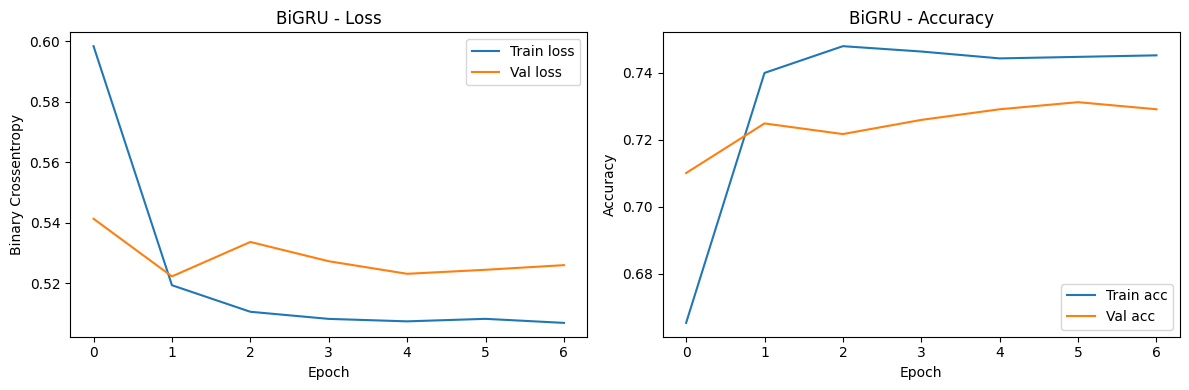

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step

[BiGRU] Test Accuracy: 0.7683
[BiGRU] Test ROC-AUC: 0.8567

[BiGRU] Classification Report:
              precision    recall  f1-score   support

           0     0.8249    0.6703    0.7396       464
           1     0.7306    0.8628    0.7912       481

    accuracy                         0.7683       945
   macro avg     0.7778    0.7665    0.7654       945
weighted avg     0.7769    0.7683    0.7659       945

[BiGRU] Confusion Matrix:
 [[311 153]
 [ 66 415]]


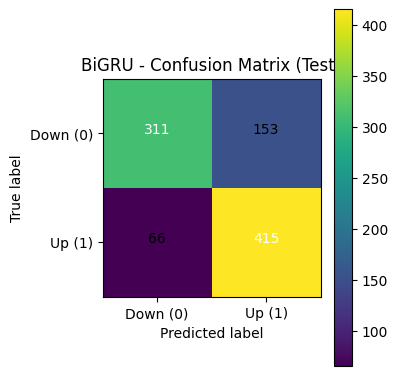


BiGRU saved as best_bigru_model_final.keras


In [ ]:
# ============================================================
# MODEL: BiGRU
# ============================================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Dropout

bigru_model = Sequential([
    Bidirectional(GRU(64, return_sequences=True), input_shape=(timesteps, n_features)),
    Dropout(0.3),
    Bidirectional(GRU(32)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

train_and_evaluate(bigru_model, "BiGRU", "best_bigru_model.keras")


# **Step: Custom Additive Attention Layer**

This custom Attention layer computes a learnable importance score for each timestep in the input sequence and produces a weighted context vector that summarizes the entire 30-day window.

**Process:**
The layer receives a 3-D tensor shaped (batch, timesteps, features) and applies a learned projection (W and b) to estimate the relevance of each timestep. These relevance scores are normalized using a softmax function to form attention weights.

**Mechanism:**

***W*** learns how each feature contributes to attention scoring.

***b*** adjusts scores across timesteps.

The layer computes alpha (attention distribution) and multiplies it with the input to emphasize important days.

The final context vector is obtained by summing the weighted features across all timesteps.

**Outcome:**
A 2-D tensor (batch, features) that highlights the most informative days in the sequence, enabling attention-enhanced models (e.g., BiLSTM + Attention) to focus on sentiment spikes or significant market movements during prediction.

In [ ]:
# ============================================================
# SIMPLE ATTENTION LAYER (RUN ONCE)
# ============================================================

from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    """
    Additive attention over time steps.
    Input:  3D tensor (batch, timesteps, features)
    Output: 2D tensor (batch, features) - context vector
    """
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name='att_weight',
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='att_bias',
            shape=(input_shape[1], 1),
            initializer='zeros',
            trainable=True
        )
        super(Attention, self).build(input_shape)

    def call(self, x):
        # x: (batch, timesteps, features)
        e = K.tanh(K.dot(x, self.W) + self.b)        # (batch, timesteps, 1)
        e = K.squeeze(e, axis=-1)                    # (batch, timesteps)
        alpha = K.softmax(e)                         # (batch, timesteps)
        alpha = K.expand_dims(alpha, axis=-1)        # (batch, timesteps, 1)
        context = x * alpha                          # (batch, timesteps, features)
        context = K.sum(context, axis=1)             # (batch, features)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


# **BiLSTM + Attention**
**Step:** Weighted Temporal Focus with Attention

The BiLSTM + Attention model enhances bidirectional encoding using a learnable attention mechanism.

**Process:**
BiLSTM generates hidden states for all 30 timesteps → Attention assigns importance weights to each day.

**Mechanism:**
High-signal days (e.g., sentiment spikes or strong market shifts) receive larger weights, producing an optimized context vector.

**Outcome:**
The most accurate model, achieving the strongest performance by emphasizing the most informative parts of each 30-day sequence.


===== BiLSTM + Attention: Summary =====


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 30, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 30, 128)        │        37,376 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_2 (Attention)         │ (None, 128)            │           158 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,855 (179.12 KB)

 Trainable params: 45,855 (179.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
136/137 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5011 - auc: 0.4951 - loss: 0.6942 - precision: 0.5065 - recall: 0.6426
Epoch 1: val_loss improved from inf to 0.69239, saving model to best_bilstm_att_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5012 - auc: 0.4953 - loss: 0.6942 - precision: 0.5065 - recall: 0.6412 - val_accuracy: 0.5185 - val_auc: 0.5887 - val_loss: 0.6924 - val_precision: 0.5117 - val_recall: 0.9179
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5219 - auc: 0.5435 - loss: 0.6887 - precision: 0.5313 - recall: 0.5218
Epoch 2: val_loss did not improve from 0.69239
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5221 - auc: 0.5437 - loss: 0.6887 - precision: 0.5314 - recall: 0.5221 - val_accuracy: 0.4974 - val_auc: 0.4346 - val_loss: 0.6953 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
136/137 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4969 - auc: 0.4917 - loss: 0.6961 - precision

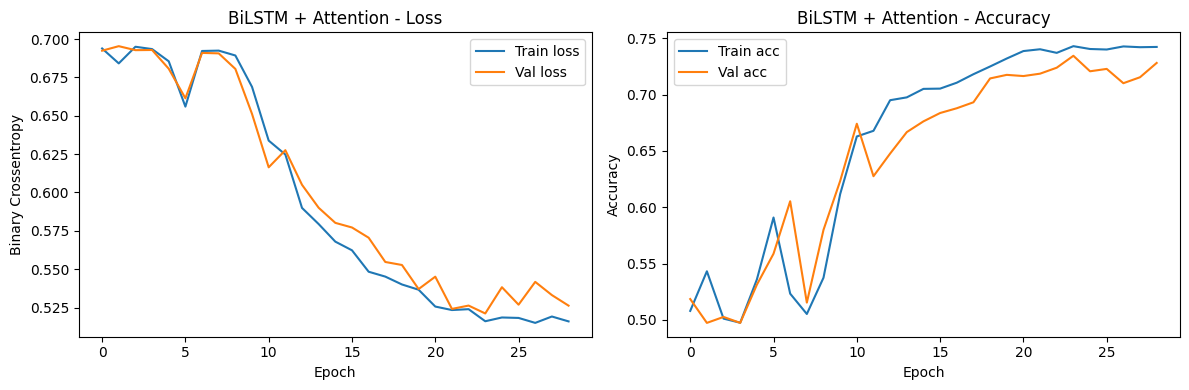

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

[BiLSTM + Attention] Test Accuracy: 0.7725
[BiLSTM + Attention] Test ROC-AUC: 0.8624

[BiLSTM + Attention] Classification Report:
              precision    recall  f1-score   support

           0     0.7986    0.7177    0.7560       464
           1     0.7519    0.8254    0.7869       481

    accuracy                         0.7725       945
   macro avg     0.7752    0.7715    0.7714       945
weighted avg     0.7748    0.7725    0.7717       945

[BiLSTM + Attention] Confusion Matrix:
 [[333 131]
 [ 84 397]]


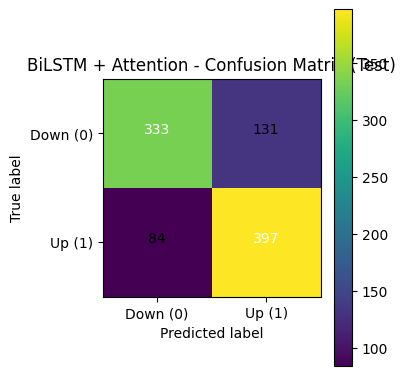


BiLSTM + Attention saved as best_bilstm_att_model_final.keras


In [ ]:
# ============================================================
# MODEL: BiLSTM + Attention
# ============================================================

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout

inputs = Input(shape=(timesteps, n_features))

x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
x = Dropout(0.3)(x)

# Attention over BiLSTM outputs
x = Attention()(x)

x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

bilstm_att_model = Model(inputs=inputs, outputs=outputs)

train_and_evaluate(bilstm_att_model, "BiLSTM + Attention", "best_bilstm_att_model.keras")


# **GRU + Attention Model**
**Step:** Attention on GRU Hidden States

This model applies the attention mechanism on top of GRU outputs.

**Process:**
GRU produces hidden states for each timestep → Attention computes relevance scores.

**Mechanism:**
Helps highlight key days, though GRU’s compact memory structure limits attention’s impact.

**Outcome:**
Performs reasonably well but inferior to BiLSTM-based attention.


===== GRU + Attention: Summary =====


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 30, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ (None, 30, 64)         │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_3 (Attention)         │ (None, 64)             │            94 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,527 (72.37 KB)

 Trainable params: 18,527 (72.37 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5133 - auc: 0.5163 - loss: 0.6932 - precision: 0.5177 - recall: 0.6215
Epoch 1: val_loss improved from inf to 0.69313, saving model to best_gru_att_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.5133 - auc: 0.5163 - loss: 0.6932 - precision: 0.5176 - recall: 0.6208 - val_accuracy: 0.5026 - val_auc: 0.5115 - val_loss: 0.6931 - val_precision: 0.5026 - val_recall: 1.0000
Epoch 2/50
135/137 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4947 - auc: 0.4979 - loss: 0.6943 - precision: 0.5026 - recall: 0.5630
Epoch 2: val_loss improved from 0.69313 to 0.69295, saving model to best_gru_att_model.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4948 - auc: 0.4978 - loss: 0.6943 - precision: 0.5025 - recall: 0.5614 - val_accuracy: 0.5026 - val_auc: 0.5063 - val_loss: 0.6929 - val_precision: 0.5026 - val_recall: 1.0000
Epoch 3/50
135/137 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5200 - auc:

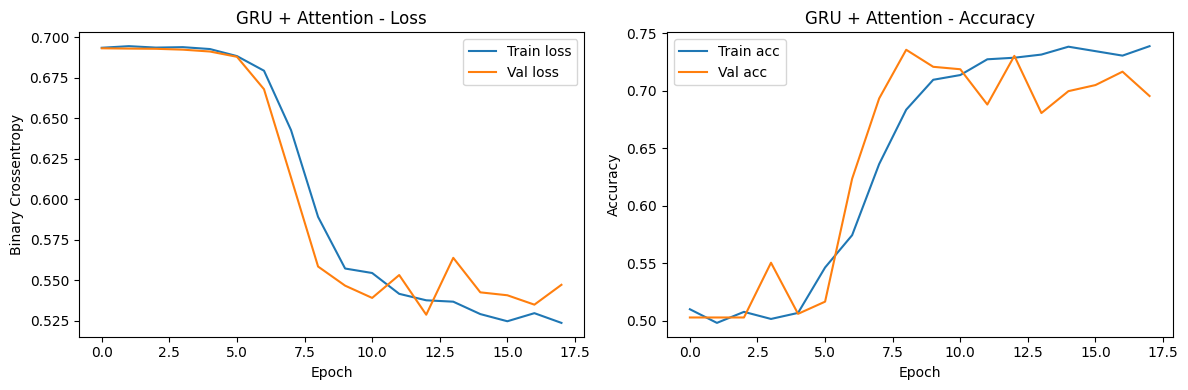

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

[GRU + Attention] Test Accuracy: 0.7439
[GRU + Attention] Test ROC-AUC: 0.8541

[GRU + Attention] Classification Report:
              precision    recall  f1-score   support

           0     0.8171    0.6164    0.7027       464
           1     0.7008    0.8669    0.7751       481

    accuracy                         0.7439       945
   macro avg     0.7590    0.7417    0.7389       945
weighted avg     0.7579    0.7439    0.7395       945

[GRU + Attention] Confusion Matrix:
 [[286 178]
 [ 64 417]]


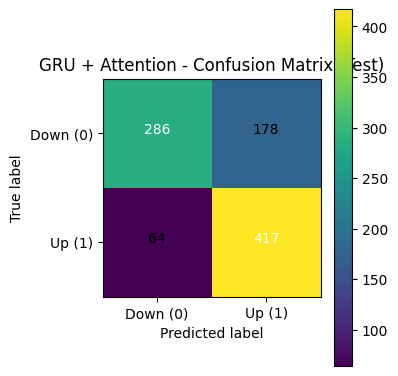


GRU + Attention saved as best_gru_att_model_final.keras


In [ ]:
# ============================================================
# MODEL: GRU + Attention
# ============================================================

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout

inputs = Input(shape=(timesteps, n_features))

x = GRU(64, return_sequences=True)(inputs)
x = Dropout(0.3)(x)

x = Attention()(x)

x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

gru_att_model = Model(inputs=inputs, outputs=outputs)

train_and_evaluate(gru_att_model, "GRU + Attention", "best_gru_att_model.keras")


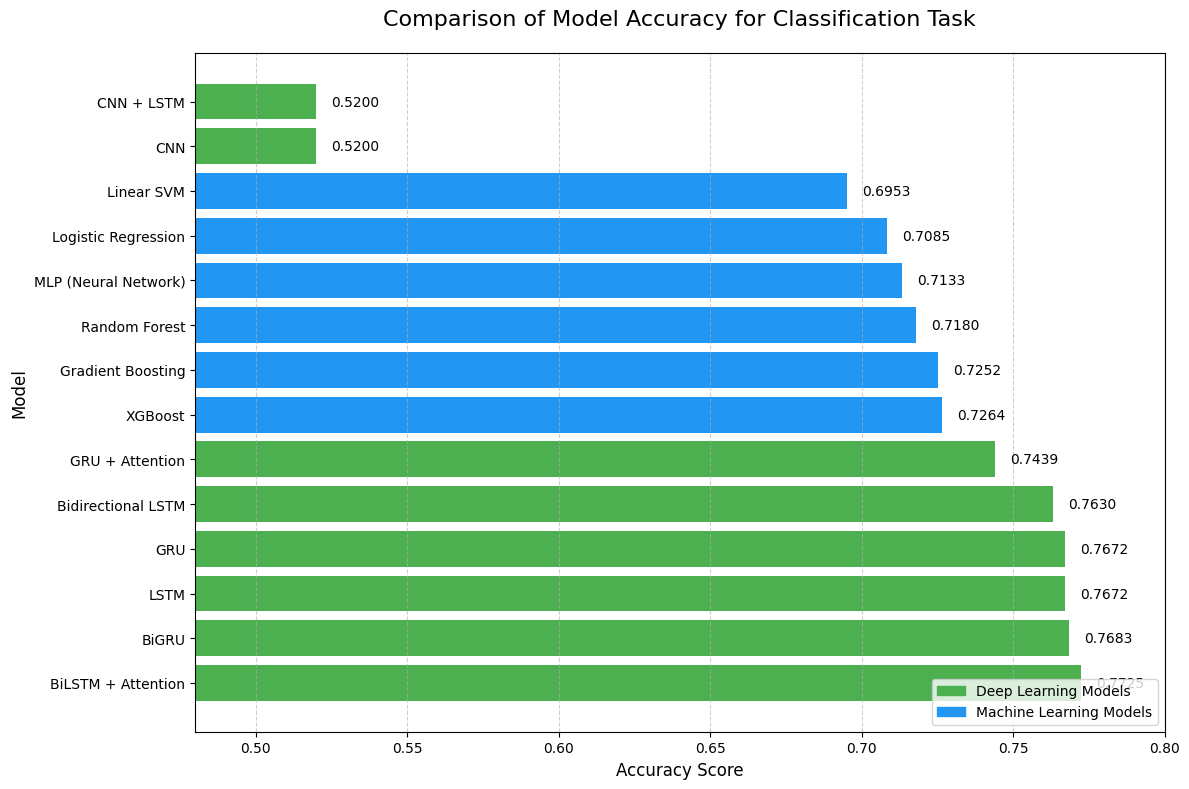

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Data Preparation ---
# Combine all model results into a single list of dictionaries
results = [
    {'Model': 'BiLSTM + Attention', 'Accuracy': 0.7725, 'Type': 'Deep Learning'},
    {'Model': 'BiGRU', 'Accuracy': 0.7683, 'Type': 'Deep Learning'},
    {'Model': 'LSTM', 'Accuracy': 0.7672, 'Type': 'Deep Learning'},
    {'Model': 'GRU', 'Accuracy': 0.7672, 'Type': 'Deep Learning'},
    {'Model': 'Bidirectional LSTM', 'Accuracy': 0.7630, 'Type': 'Deep Learning'},
    {'Model': 'GRU + Attention', 'Accuracy': 0.7439, 'Type': 'Deep Learning'},
    {'Model': 'XGBoost', 'Accuracy': 0.7264, 'Type': 'Machine Learning'},
    {'Model': 'Gradient Boosting', 'Accuracy': 0.7252, 'Type': 'Machine Learning'},
    {'Model': 'Random Forest', 'Accuracy': 0.7180, 'Type': 'Machine Learning'},
    {'Model': 'MLP (Neural Network)', 'Accuracy': 0.7133, 'Type': 'Machine Learning'},
    {'Model': 'Logistic Regression', 'Accuracy': 0.7085, 'Type': 'Machine Learning'},
    {'Model': 'Linear SVM', 'Accuracy': 0.6953, 'Type': 'Machine Learning'},
    {'Model': 'CNN', 'Accuracy': 0.5200, 'Type': 'Deep Learning'},
    {'Model': 'CNN + LSTM', 'Accuracy': 0.5200, 'Type': 'Deep Learning'},
]

df = pd.DataFrame(results)

# Sort the data by accuracy in descending order for better visualization
df = df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Define colors for each model type
color_map = {
    'Deep Learning': '#4CAF50',  # Green for DL
    'Machine Learning': '#2196F3' # Blue for ML
}
colors = df['Type'].map(color_map)

# --- Plotting ---
plt.figure(figsize=(12, 8))
bars = plt.barh(df['Model'], df['Accuracy'], color=colors)

# Add title and labels
plt.title('Comparison of Model Accuracy for Classification Task', fontsize=16, pad=20)
plt.xlabel('Accuracy Score', fontsize=12)
plt.ylabel('Model', fontsize=12)

# Set the x-axis limits to clearly show differences and to include the 0.52 minimum
plt.xlim(0.48, 0.80)

# Add the accuracy score text to each bar
for bar in bars:
    # Ensure text is slightly outside the bar, but inside the plot area
    xval = bar.get_width()
    plt.text(xval + 0.005, bar.get_y() + bar.get_height()/2,
             f'{xval:.4f}',
             va='center',
             fontsize=10)

# Create custom legend handles
from matplotlib.patches import Patch
legend_handles = [
    Patch(color=color_map['Deep Learning'], label='Deep Learning Models'),
    Patch(color=color_map['Machine Learning'], label='Machine Learning Models')
]
plt.legend(handles=legend_handles, loc='lower right', fontsize=10)

# Add grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Improve layout
plt.tight_layout()

# Save the plot to a file (optional, but good practice)
# plt.savefig('model_accuracy_comparison.png')

plt.show()

# The script above will generate and display the chart when run.